In [1]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from PIL import Image
from io import BytesIO
import tensorflow as tf
%matplotlib inline

# identify bucket
role = get_execution_role()
bucket='my-bucket'
# image size
imsize = 224
# batch size
bsize = 10

# change limit to 10,000 then load data from s3
client = boto3.client('s3')
paginator = client.get_paginator('list_objects')
page_iterator = paginator.paginate(Bucket=bucket, PaginationConfig={'MaxItems': 10000}, Prefix="data/train/")

# count number of data
n = 0
files = []
for page in page_iterator:
    n += len(page['Contents'])
    for file in page['Contents']:
        files.append(file['Key'])
    
files = files[1:]
print("number of data:", n-1)
print(files[0:5])

number of data: 9999
['data/train/busy/20150703_0805_15.jpg', 'data/train/busy/20150703_0805_17.jpg', 'data/train/busy/20150703_0805_29.jpg', 'data/train/busy/20150703_0805_45.jpg', 'data/train/busy/20150703_0805_8.jpg']


In [2]:
from random import shuffle
shuffle(files)

## seperate to 100 each
file_batches = []
n = 0
file_batch = []
for file in files:
    file_batch.append(file)
    n += 1
    if n % 500 == 0:
        file_batches.append(file_batch)
        file_batch = []

file_batches.append(file_batch)
print(file_batch[0:10])

['data/train/busy/20150703_1445_1.jpg', 'data/train/busy/20150708_1340_22.jpg', 'data/train/busy/20150708_1400_48.jpg', 'data/train/busy/20150708_1105_42.jpg', 'data/train/busy/20150703_1410_13.jpg', 'data/train/free/20150703_1650_11.jpg', 'data/train/busy/20150708_1520_34.jpg', 'data/train/busy/20150703_0935_2.jpg', 'data/train/busy/20150703_1110_4.jpg', 'data/train/busy/20150708_1155_43.jpg']


In [3]:
keras = tf.keras

base_model = tf.keras.applications.MobileNetV2(input_shape=(imsize, imsize, 3), include_top=False, weights='imagenet')

base_model.trainable = False

average_layer_1 = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer_1 = keras.layers.Dropout(rate=0.5)

dense_layer_1 = keras.layers.Dense(1280)

average_layer_2 = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer_2 = keras.layers.Dropout(rate=0.5)

dense_layer_2 = keras.layers.Dense(640)

average_layer_3 = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer_3 = keras.layers.Dropout(rate=0.5)

dense_layer_3 = keras.layers.Dense(320)

average_layer_4 = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer_4 = keras.layers.Dropout(rate=0.5)

dense_layer_4 = keras.layers.Dense(160)

average_layer_5 = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer_5 = keras.layers.Dropout(rate=0.5)

dense_layer_5 = keras.layers.Dense(80)

average_layer_6 = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer_6 = keras.layers.Dropout(rate=0.5)

dense_layer_6 = keras.layers.Dense(40)

average_layer_7 = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer_7 = keras.layers.Dropout(rate=0.5)

dense_layer_7 = keras.layers.Dense(20)

average_layer_last = tf.keras.layers.AveragePooling2D(padding="same")

dropout_layer = keras.layers.Dropout(rate=0.5)

prediction_layer = keras.layers.Dense(1)

model = tf.keras.Sequential([base_model,
                             average_layer_1,
                             dropout_layer_1,
                             dense_layer_1,
                             average_layer_2,
                             dropout_layer_2,
                             dense_layer_2,
                             average_layer_3,
                             dropout_layer_3,
                             dense_layer_3,
                             average_layer_4,
                             dropout_layer_4,
                             dense_layer_4,
                             average_layer_5,
                             dropout_layer_5,
                             dense_layer_5,
                             average_layer_6,
                             dropout_layer_6,
                             dense_layer_6,
                             average_layer_7,
                             dropout_layer_7,
                             dense_layer_7,
                             average_layer_last,
                             dropout_layer,
                             prediction_layer])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 4, 4, 1280)        0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1280)        0         
_________________________________________________________________
dense (Dense)                (None, 4, 4, 1280)        1639680   
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 1280)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1280)        0         
____

### For test, use only 200 data

In [5]:
# collect image as array and label
label = []
im = np.empty((1,imsize,imsize,3), int)
n = 0
for file in file_batches[0]:
    if "busy" in file:
        label.append(1)
    else :
        label.append(0)
    # collect image
    img = Image.open(BytesIO(client.get_object(Bucket=bucket, Key=file)['Body'].read())).resize((imsize,imsize))
    im = np.append(im, ((np.asarray(img, dtype="int32")/127.5) - 1).reshape((1,imsize,imsize,3)), axis=0)
    n += 1
im = im[1:]

print(im.shape)
print(len(label))

(500, 224, 224, 3)
500


In [6]:
# convert to tensor
X = tf.convert_to_tensor(im[0:450])
y = tf.convert_to_tensor(label[0:450])
Xv = tf.convert_to_tensor(im[-50:])
yv = tf.convert_to_tensor(label[-50:])

In [6]:
# select optimizer and save model weight
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.summary()
# ini weight
model.save_weights('untrained_weight.h5')

epochs = 5

In [7]:
# train model
history = model.fit(x = X, y = y, epochs=epochs, steps_per_epoch=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
20/20 [==============================] - 52s 3s/step - loss: 7.6571 - acc: 0.4887
Epoch 2/5
20/20 [==============================] - 22s 1s/step - loss: 7.5406 - acc: 0.4985
Epoch 3/5
20/20 [==============================] - 22s 1s/step - loss: 7.4661 - acc: 0.5017
Epoch 4/5
20/20 [==============================] - 22s 1s/step - loss: 7.3065 - acc: 0.5133
Epoch 5/5
20/20 [==============================] - 22s 1s/step - loss: 7.1944 - acc: 0.5194


In [8]:
# check result
results = model.evaluate(Xv, yv, batch_size=10, steps=1)
print('test loss, test acc:', results)

1/1 [==============================] - 3s 3s/step - loss: 3.2146 - acc: 0.7016
test loss, test acc: [3.2146077156066895, 0.7016]


In [9]:
# reset weight
model.load_weights('untrained_weight.h5')

### Start using loop for all data

In [ ]:
# init
imsize = 224
results_loss = []
results_acc = []

# select optimizer
base_learning_rate = 0.000005
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
epochs = 10

for n in range(20):
    
    i = 0
    for file_batch in file_batches:

        label = []
        im = np.empty((1,imsize,imsize,3), int)
        ## for 1 batch
        print("This is loop number:", n)
        print("This is batch number: " + str(i) + " out of " + str(len(file_batches)))

        # collect images and labels
        print("collecting data")
        for file in file_batch:
            if "busy" in file:
                label.append(1)
            else :
                label.append(0)
            # collect image
            img = Image.open(BytesIO(client.get_object(Bucket=bucket, Key=file)['Body'].read())).resize((imsize,imsize))
            im = np.append(im, ((np.asarray(img, dtype="int32")/127.5) - 1).reshape((1,imsize,imsize,3)), axis=0)
        im = im[1:]

        print("number of image:", len(label))

        # convert to tensor
        # last batch does not have 500 data
        if i != len(file_batches):
            X = tf.convert_to_tensor(im[0:450])
            y = tf.convert_to_tensor(label[0:450])
            Xv = tf.convert_to_tensor(im[-50:])
            yv = tf.convert_to_tensor(label[-50:])
        # in last batch, just train
        else :
            X = tf.convert_to_tensor(im)
            y = tf.convert_to_tensor(label)

        # train
        print("start training")
        history = model.fit(x = X, y = y, epochs=epochs, steps_per_epoch=10)

        # test with validation
        print("evaluating")
        result = model.evaluate(Xv, yv, batch_size=10, steps=1)
        results_loss.append(result[0])
        results_acc.append(result[1])
        print('test loss, test acc:', result)

        i += 1
        
        if i % 10 == 0:
            #save model
            print("saving the model")
            model.save('trained_carpark_MobileNetV2.h5')

    if n == 2:
        base_learning_rate = 0.0000005
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    if n == 5:
        base_learning_rate = 0.00000005
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    if n == 7:
        base_learning_rate = 0.000000005
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    

This is loop number: 0
This is batch number: 0 out of 20
collecting data
number of image: 500
start training
Epoch 1/10
10/10 [==============================] - 39s 4s/step - loss: 4.0750 - acc: 0.7339
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 4.0628 - acc: 0.7349
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 4.0711 - acc: 0.7339
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 4.0711 - acc: 0.7344
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 4.0692 - acc: 0.7343
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 4.0536 - acc: 0.7355
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 4.0687 - acc: 0.7346
Epoch 8/10
10/10 [==============================] - 11s 1s/step - loss: 4.0529 - acc: 0.7352
Epoch 9/10
10/10 [==============================] - 11s 1s/step - loss: 4.0608 - acc: 0.7341
Epoch 10/10
10/10 [==============================] - 1

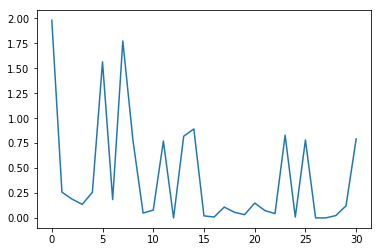

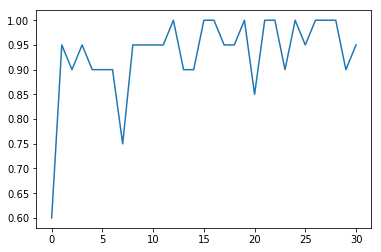

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results_loss)
plt.show()
plt.plot(results_acc)
plt.show()

In [12]:
#save model
model.save('trained_carpark_MobileNetV2.h5')

### Resume training

In [7]:
# load trained model
model = tf.keras.models.load_model('trained_carpark_MobileNetV2.h5')

# Show the model architecture
model.summary()

# check result
results = model.evaluate(Xv, yv, batch_size=10, steps=1)
print('test loss, test acc:', results)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 4, 4, 1280)        0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1280)        0         
_________________________________________________________________
dense (Dense)                (None, 4, 4, 1280)        1639680   
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 1280)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1280)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 2, 2, 640)         8